### IMPORTS

In [1]:
import pandas as pd
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
import math
from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from time import time

### Carregando imagens e selecionando aleatoriamente o indice de teste

Utilizaremos 9 imagens para treino e 1 para teste, a nossa imagem de teste deve ser definida aleatoriamente.

In [2]:
total_photos = 40
total_per_person = 10
test_index = random.randint(1,10)

# all picture from all people
all_images = list() #people raw

# image referent the index to test
test_images = list() # subjects

# images to training our model
training_images = list()

for j in range(1, total_photos+1):
    for i in range(1, total_per_person+1):
        all_images.append(np.array(cv2.imread(f'./orl_faces/s{j}/{i}.pgm',0)))
        if i != test_index:
            training_images.append(np.array(cv2.imread(f'./orl_faces/s{j}/{i}.pgm',0)))
        else:
            test_images.append(np.array(cv2.imread(f'./orl_faces/s{j}/{i}.pgm',0)))

print(f">Test Index: {test_index} \n>dataset size: {len(all_images)} \n>training images: {len(training_images)} \n>test images: {len(test_images)}")

>Test Index: 9 
>dataset size: 400 
>training images: 360 
>test images: 40


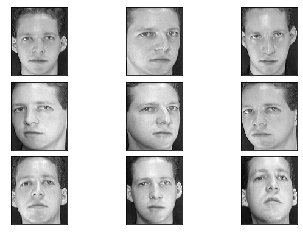

In [3]:
show_pictures = 3

for j in range(0, show_pictures*show_pictures, show_pictures):
    for i in range(1, show_pictures+1):
        plt.subplot(show_pictures, show_pictures, i + j)
        plt.imshow(all_images[i-1 + j], cmap = 'gray')
        plt.xticks([]), plt.yticks([])
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)
plt.show()

### Aplicação da transformada de fourier em cada imagem

O array images_fourier contém as imagens de treinamento ao passar pela transformada, e, da mesma forma, o images_unique_fourier contém as imagens de teste transformadas

In [4]:
training_images_fourier = [np.fft.fft2(person) for person in training_images]
test_images_fourier = [np.fft.fft2(person) for person in test_images]

Para cada imagem em que foi aplicada a transformada de fourier, se faz necessário aplicar um shift para trazer a informação da transformada para o meio da imagem:
- trainig_images_fourier_shift -> todas as imagens de treino com o shift aplicado
- test_images_fourier_shift -> todas as imagens de test com o shift aplicado

In [5]:
trainig_images_fourier_shift = [np.fft.fftshift(person) for person in training_images_fourier]
test_images_fourier_shift = [np.fft.fftshift(person) for person in test_images_fourier] 

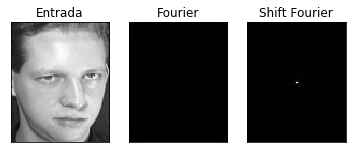

In [6]:
plt.subplot(131)
plt.imshow(all_images[test_index], cmap = 'gray')
plt.title('Entrada'), plt.xticks([]), plt.yticks([])

plt.subplot(132)
plt.imshow(np.abs(training_images_fourier[test_index]), cmap = 'gray')
plt.title('Fourier'), plt.xticks([]), plt.yticks([])

plt.subplot(133)
plt.imshow(np.abs(trainig_images_fourier_shift[test_index]), cmap = 'gray')
plt.title('Shift Fourier'), plt.xticks([]), plt.yticks([])

plt.show()

## Redimensionamento das imagens

Como definido na especificação, vamos avaliar o Erro Quadrado Médio (MSE) em várias dimensões [2x2 -> 50x50], e, calcular a acurácia de cada dimensão.

In [7]:
def redimensionar_imagem(off_set, imagem):
    largura = 92
    altura = 112

    centro_largura = largura//2
    centro_altura = altura//2

    raio = off_set//2
    
    os = 0
    if off_set % 2 != 0:
        os = -1
    
    x = centro_altura-raio+os
    xx = centro_altura+raio
    y = centro_largura-raio+os
    yy = centro_largura+raio
    return imagem[x:xx,y:yy]

original:  (360, 112, 92)  redimensionado:  (50, 50)


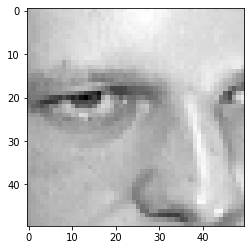

In [8]:
redimensionado = redimensionar_imagem(50,all_images[test_index])
print('original: ', np.array(trainig_images_fourier_shift).shape, " redimensionado: ", redimensionado.shape)
plt.imshow(redimensionado, 'gray')

## KNN com MSE

#### Labels para o KNN

In [9]:
labels = [i for i in range(40) for j in range(9)]
print(labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 29, 29, 30, 30, 3

In [10]:
import progressbar

interval = 50

bar = progressbar.ProgressBar(maxval=interval, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
global count
count = 0

# Cenários

Na especificação do projeto temos que tomar para análise quatro cenários tendo em vista nosso agrupamente de imagens para treino e teste, aplicaremos o KNN com o MSE nos seguintes formatos:

- Apenas parte Real
- Apenas parte Imaginária
- Real + Imaginário
- Menor valor das permutações (  (Real, Real), (Imag, Imag), (Real, Imag), (Imag, Real)  )
- |Real+Imaginário|

Aplicando cada uma dos cenário teremos o seguinte padrão da análise:
- KNN com o cenário desejado
- Acurácia para dimensão
- Histograma para análise da acurácia em cada dimensão

In [11]:
def knn(subjects, dataset, mode):
    
    nearest_indexes = []
    nearest_labels = []
    
    for i, labeless_image in enumerate(subjects): #T0
        
        nearest = math.inf
        nearest_index = 0
        
        for j, labeled_image in enumerate(dataset): #C0
            
            if mode == 'real':
                mse = mean_squared_error(labeled_image.real, labeless_image.real)
            if mode == 'imag':
                mse = mean_squared_error(labeled_image.imag, labeless_image.imag)
            if mode == 'real_imag':
                mse_real = mean_squared_error(labeled_image.real, labeless_image.real)
                mse_imag = mean_squared_error(labeled_image.imag, labeless_image.imag)
                mse = mse_real + mse_imag
            if mode == 'real_imag_menor':
                mse_real = mean_squared_error(labeled_image.real, labeless_image.real)
                mse_imag = mean_squared_error(labeled_image.imag, labeless_image.imag)
                mse_real_imag = mean_squared_error(labeled_image.imag, labeless_image.real)
                mse_imag_real = mean_squared_error(labeled_image.real, labeless_image.imag)
                mse = min(mse_real, mse_imag, mse_real_imag, mse_imag_real)
            if mode == 'merge_real_imag':
                mse = mean_squared_error(
                    abs(labeless_image.real+labeless_image.imag),
                    abs(labeled_image.real+labeled_image.imag)                     
                )
            if mse < nearest:
                nearest = mse
                nearest_index = j
        
        nearest_indexes.append(nearest_index)
        nearest_labels.append(labels[nearest_index])
        
    return nearest_labels

# Cenários:

- ## Real

In [12]:
labels_predict_real = []

inicio = time()

bar.start()
for dim in range(2, 51):
    subject = [redimensionar_imagem(dim, i) for i in test_images_fourier_shift]
    dataset = [redimensionar_imagem(dim, i) for i in trainig_images_fourier_shift]
    labels_predict_real.append(knn(subject, dataset, 'real'))
    bar.update(dim)
    
bar.finish()

fim = time()
print('\n>Tempo de Execução: ', fim - inicio)

np.array(labels_predict_real).shape


>Tempo de Execução:  97.38609385490417


(49, 40)


>Resultado da acurácia para cada dimensão:

Dimensão  2, [apenas Real]: 0.775 31
Dimensão  3, [apenas Real]: 0.925 37
Dimensão  4, [apenas Real]: 0.9 36
Dimensão  5, [apenas Real]: 0.9 36
Dimensão  6, [apenas Real]: 0.925 37
Dimensão  7, [apenas Real]: 0.95 38
Dimensão  8, [apenas Real]: 0.95 38
Dimensão  9, [apenas Real]: 0.95 38
Dimensão 10, [apenas Real]: 0.95 38
Dimensão 11, [apenas Real]: 0.95 38
Dimensão 12, [apenas Real]: 0.95 38
Dimensão 13, [apenas Real]: 0.95 38
Dimensão 14, [apenas Real]: 0.95 38
Dimensão 15, [apenas Real]: 0.95 38
Dimensão 16, [apenas Real]: 0.95 38
Dimensão 17, [apenas Real]: 0.95 38
Dimensão 18, [apenas Real]: 0.95 38
Dimensão 19, [apenas Real]: 0.95 38
Dimensão 20, [apenas Real]: 0.95 38
Dimensão 21, [apenas Real]: 0.95 38
Dimensão 22, [apenas Real]: 0.95 38
Dimensão 23, [apenas Real]: 0.95 38
Dimensão 24, [apenas Real]: 0.95 38
Dimensão 25, [apenas Real]: 0.95 38
Dimensão 26, [apenas Real]: 0.95 38
Dimensão 27, [apenas Real]: 0.95 38
Dimensão 28, [apen

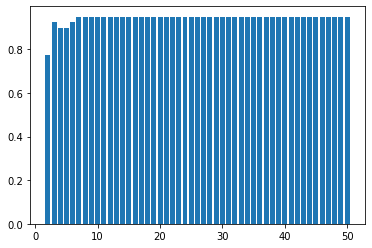

In [13]:
y_true = [i for i in range(0,40)]

graph_real = []

print('\n>Resultado da acurácia para cada dimensão:\n')

for i, y_pred in enumerate(labels_predict_real):
    print("Dimensão {:2}, [apenas Real]: {} {}" .format((i+2), accuracy_score(y_true, y_pred), accuracy_score(y_true, y_pred, normalize=False)))
    graph_real.append([accuracy_score(y_true, y_pred), i+2])
    
graph_real = np.array(graph_real).transpose()

print('\n>Histograma para visualização da acurácia:\n')

plt.bar(graph_real[1], graph_real[0])
plt.show()

- ## Imaginário

In [14]:
dimensoes = [i for i in range(2,51)]

inicio = time()

labels_predict_imag = []
bar.start()
for dim in dimensoes:
    subject = [redimensionar_imagem(dim, i) for i in test_images_fourier_shift]
    dataset = [redimensionar_imagem(dim, i) for i in trainig_images_fourier_shift]
    labels_predict_imag.append(knn(subject, dataset, 'imag'))
    bar.update(dim)

bar.finish()

fim = time()
print('\n>Tempo de Execução: ', fim - inicio)

np.array(labels_predict_imag).shape


>Tempo de Execução:  98.05825328826904


(49, 40)


>Resultado da acurácia para cada dimensão:

Dimensão  2, [apenas imaginário]: 0.575 23
Dimensão  3, [apenas imaginário]: 0.8 32
Dimensão  4, [apenas imaginário]: 0.875 35
Dimensão  5, [apenas imaginário]: 0.925 37
Dimensão  6, [apenas imaginário]: 0.925 37
Dimensão  7, [apenas imaginário]: 0.925 37
Dimensão  8, [apenas imaginário]: 0.925 37
Dimensão  9, [apenas imaginário]: 0.925 37
Dimensão 10, [apenas imaginário]: 0.9 36
Dimensão 11, [apenas imaginário]: 0.9 36
Dimensão 12, [apenas imaginário]: 0.9 36
Dimensão 13, [apenas imaginário]: 0.9 36
Dimensão 14, [apenas imaginário]: 0.925 37
Dimensão 15, [apenas imaginário]: 0.9 36
Dimensão 16, [apenas imaginário]: 0.925 37
Dimensão 17, [apenas imaginário]: 0.925 37
Dimensão 18, [apenas imaginário]: 0.925 37
Dimensão 19, [apenas imaginário]: 0.925 37
Dimensão 20, [apenas imaginário]: 0.925 37
Dimensão 21, [apenas imaginário]: 0.925 37
Dimensão 22, [apenas imaginário]: 0.925 37
Dimensão 23, [apenas imaginário]: 0.925 37
Dimensão 24, [apenas 

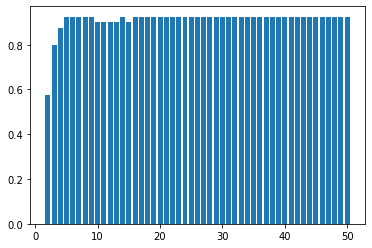

In [15]:
from sklearn.metrics import accuracy_score

y_true = [i for i in range(0,40)]

graph_imag = []

print('\n>Resultado da acurácia para cada dimensão:\n')

for i, y_pred in enumerate(labels_predict_imag):
    print("Dimensão {:2}, [apenas imaginário]: {} {}" .format((i+2), accuracy_score(y_true, y_pred), accuracy_score(y_true, y_pred, normalize=False)))
    graph_imag.append([accuracy_score(y_true, y_pred), i+2])
    
graph_imag = np.array(graph_imag).transpose()

print('\n>Histograma para visualização da acurácia:\n')

plt.bar(graph_imag[1], graph_imag[0])
plt.show()

- ## Real + Imaginário

In [16]:
dimensoes = [i for i in range(2,51)]

inicio = time()

labels_predict_real_imag = []
bar.start()
for dim in dimensoes:
    subject = [redimensionar_imagem(dim, i) for i in test_images_fourier_shift]
    dataset = [redimensionar_imagem(dim, i) for i in trainig_images_fourier_shift]
    labels_predict_real_imag.append(knn(subject, dataset, 'real_imag'))
    bar.update(dim)

bar.finish()

fim = time()
print('\n>Tempo de Execução: ', fim - inicio)

np.array(labels_predict_real_imag).shape


>Tempo de Execução:  191.25904059410095


(49, 40)


>Resultado da acurácia para cada dimensão:

Dimensão  2, [Real+Imaginário] 0.875 35
Dimensão  3, [Real+Imaginário] 0.95 38
Dimensão  4, [Real+Imaginário] 0.975 39
Dimensão  5, [Real+Imaginário] 0.95 38
Dimensão  6, [Real+Imaginário] 0.95 38
Dimensão  7, [Real+Imaginário] 0.95 38
Dimensão  8, [Real+Imaginário] 0.95 38
Dimensão  9, [Real+Imaginário] 0.95 38
Dimensão 10, [Real+Imaginário] 0.95 38
Dimensão 11, [Real+Imaginário] 0.95 38
Dimensão 12, [Real+Imaginário] 0.95 38
Dimensão 13, [Real+Imaginário] 0.975 39
Dimensão 14, [Real+Imaginário] 0.975 39
Dimensão 15, [Real+Imaginário] 0.975 39
Dimensão 16, [Real+Imaginário] 0.975 39
Dimensão 17, [Real+Imaginário] 0.975 39
Dimensão 18, [Real+Imaginário] 0.975 39
Dimensão 19, [Real+Imaginário] 0.975 39
Dimensão 20, [Real+Imaginário] 0.975 39
Dimensão 21, [Real+Imaginário] 0.975 39
Dimensão 22, [Real+Imaginário] 0.975 39
Dimensão 23, [Real+Imaginário] 0.975 39
Dimensão 24, [Real+Imaginário] 0.975 39
Dimensão 25, [Real+Imaginário] 0.975 39
Dime

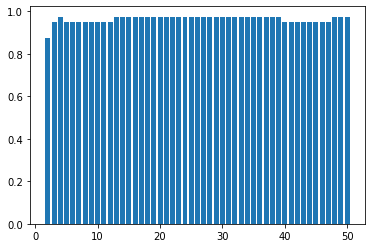

In [17]:
y_true = [i for i in range(0,40)]

graph_real_imag = []

print('\n>Resultado da acurácia para cada dimensão:\n')

for i, y_pred in enumerate(labels_predict_real_imag):
    print("Dimensão {:2}, [Real+Imaginário] {} {}" .format((i+2), accuracy_score(y_true, y_pred), accuracy_score(y_true, y_pred, normalize=False)))
    graph_real_imag.append([accuracy_score(y_true, y_pred), i+2])

print('\n>Histograma para visualização da acurácia:\n')    

graph_real_imag = np.array(graph_real_imag).transpose()

plt.bar(graph_real_imag[1], graph_real_imag[0])
plt.show()

- ## Menor valor da permutação Real e Imag [(R,R),(R,I),(I,R),(I,I)]

In [18]:
dimensoes = [i for i in range(2,51)]

inicio = time()

labels_predict_real_imag_perm = []
bar.start()
for dim in dimensoes:
    subject = [redimensionar_imagem(dim, i) for i in test_images_fourier_shift]
    dataset = [redimensionar_imagem(dim, i) for i in trainig_images_fourier_shift]
    labels_predict_real_imag_perm.append(knn(subject, dataset, 'real_imag_menor'))
    bar.update(dim)

bar.finish()

fim = time()
print('\n>Tempo de Execução: ', fim - inicio)

np.array(labels_predict_real_imag_perm).shape


>Tempo de Execução:  440.9462912082672


(49, 40)


>Resultado da acurácia para cada dimensão:

Dimensão  2, min[Permutações] 0.625 25
Dimensão  3, min[Permutações] 0.825 33
Dimensão  4, min[Permutações] 0.9 36
Dimensão  5, min[Permutações] 0.9 36
Dimensão  6, min[Permutações] 0.925 37
Dimensão  7, min[Permutações] 0.95 38
Dimensão  8, min[Permutações] 0.95 38
Dimensão  9, min[Permutações] 0.95 38
Dimensão 10, min[Permutações] 0.95 38
Dimensão 11, min[Permutações] 0.95 38
Dimensão 12, min[Permutações] 0.95 38
Dimensão 13, min[Permutações] 0.95 38
Dimensão 14, min[Permutações] 0.975 39
Dimensão 15, min[Permutações] 0.95 38
Dimensão 16, min[Permutações] 0.975 39
Dimensão 17, min[Permutações] 0.975 39
Dimensão 18, min[Permutações] 0.975 39
Dimensão 19, min[Permutações] 0.975 39
Dimensão 20, min[Permutações] 0.975 39
Dimensão 21, min[Permutações] 0.975 39
Dimensão 22, min[Permutações] 0.975 39
Dimensão 23, min[Permutações] 0.975 39
Dimensão 24, min[Permutações] 0.975 39
Dimensão 25, min[Permutações] 0.975 39
Dimensão 26, min[Permutações] 0

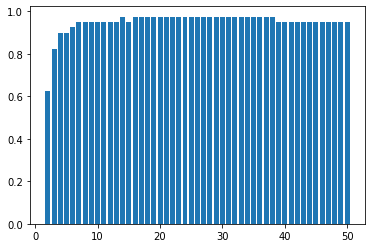

In [19]:
print('\n>Resultado da acurácia para cada dimensão:\n')
y_true = [i for i in range(0,40)]

graph_real_imag_perm = []

for i, y_pred in enumerate(labels_predict_real_imag_perm):
    print("Dimensão {:2}, min[Permutações] {} {}" .format((i+2), accuracy_score(y_true, y_pred), accuracy_score(y_true, y_pred, normalize=False)))
    graph_real_imag_perm.append([accuracy_score(y_true, y_pred), i+2])
    
print('\n>Histograma para visualização da acurácia:\n')

graph_real_imag_perm = np.array(graph_real_imag_perm).transpose()

plt.bar(graph_real_imag_perm[1], graph_real_imag_perm[0])
plt.show()

- ## |Real+Imaginário|

In [20]:
dimensoes = [i for i in range(2,51)]

inicio = time()

labels_predict_merge = []
bar.start()
for dim in dimensoes:
    subject = [redimensionar_imagem(dim, i) for i in test_images_fourier_shift]
    dataset = [redimensionar_imagem(dim, i) for i in trainig_images_fourier_shift]
    labels_predict_merge.append(knn(subject, dataset, 'merge_real_imag'))
    bar.update(dim)

bar.finish()

fim = time()
print('\n>Tempo de Execução: ', fim - inicio)

np.array(labels_predict_merge).shape


>Tempo de Execução:  105.3903329372406


(49, 40)


>Resultado da acurácia para cada dimensão:

Dimensão  2, [ |Real+Imaginário| ] 0.575 23
Dimensão  3, [ |Real+Imaginário| ] 0.825 33
Dimensão  4, [ |Real+Imaginário| ] 0.975 39
Dimensão  5, [ |Real+Imaginário| ] 0.975 39
Dimensão  6, [ |Real+Imaginário| ] 0.975 39
Dimensão  7, [ |Real+Imaginário| ] 0.975 39
Dimensão  8, [ |Real+Imaginário| ] 0.95 38
Dimensão  9, [ |Real+Imaginário| ] 0.95 38
Dimensão 10, [ |Real+Imaginário| ] 0.95 38
Dimensão 11, [ |Real+Imaginário| ] 0.975 39
Dimensão 12, [ |Real+Imaginário| ] 0.975 39
Dimensão 13, [ |Real+Imaginário| ] 0.975 39
Dimensão 14, [ |Real+Imaginário| ] 0.975 39
Dimensão 15, [ |Real+Imaginário| ] 0.975 39
Dimensão 16, [ |Real+Imaginário| ] 0.975 39
Dimensão 17, [ |Real+Imaginário| ] 0.975 39
Dimensão 18, [ |Real+Imaginário| ] 0.975 39
Dimensão 19, [ |Real+Imaginário| ] 0.975 39
Dimensão 20, [ |Real+Imaginário| ] 0.975 39
Dimensão 21, [ |Real+Imaginário| ] 0.975 39
Dimensão 22, [ |Real+Imaginário| ] 1.0 40
Dimensão 23, [ |Real+Imaginário| ] 1

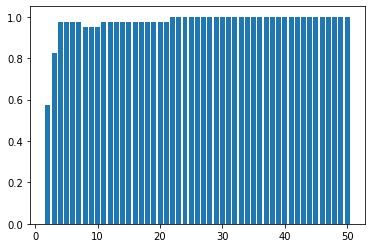

In [21]:
print('\n>Resultado da acurácia para cada dimensão:\n')
y_true = [i for i in range(0,40)]

graph_real_imag_merge = []

for i, y_pred in enumerate(labels_predict_merge):
    print("Dimensão {:2}, [ |Real+Imaginário| ] {} {}" .format((i+2), accuracy_score(y_true, y_pred), accuracy_score(y_true, y_pred, normalize=False)))
    graph_real_imag_merge.append([accuracy_score(y_true, y_pred), i+2])
    
print('\n>Histograma para visualização da acurácia:\n')    

graph_real_imag_merge = np.array(graph_real_imag_merge).transpose()

plt.bar(graph_real_imag_merge[1], graph_real_imag_merge[0])
plt.show()